In [1]:
# utility function for printing score of a regression algorithm

def rmsle(y, y_): # rmsle loss formula - Root Mean Squared Log Error
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

def print_score(algo, score, params):
    print('%s score is %f with params %s' % (algo, score, json.dumps(params)))

In [2]:
import numpy as np # we use numpy for linear algebra ops
import pandas as pd # we use pandas for csv ops
import sklearn, json # we use sklearn for ml algos
from sklearn import preprocessing as pp # preprocessing ops
from sklearn import linear_model # regression algorithms
from sklearn.impute import SimpleImputer # imputation ops
import sklearn.model_selection as ms # spliting ops
import sklearn.metrics as metrics
from sklearn.decomposition import PCA # reduction ops
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

data_frame = pd.read_csv('train.csv')
data_frame = data_frame.set_index('Id') # set Id as index for indexing rows

test_data_frame = pd.read_csv('test.csv')
test_data_frame = test_data_frame.set_index('Id')
data_frame.head() # showing the first 5 rows



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# printing the average of all selling prices
price = data_frame.SalePrice
print("Sale price AVG: " + "${:,.0f}".format(price.mean()))

Sale price AVG: $180,921


In [4]:
data_frame = data_frame.drop('SalePrice', axis=1) # dropping SalePrice cloumn for training - our model must not to see the labels

In [5]:
total_data_frame = data_frame.append(test_data_frame) # merging all data
total_data_frame.shape # 79 features - cause we deleted the SalePrice column

(2919, 79)

In [6]:
total_features = 'MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition'.split(',')
numeric_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','TotalBsmtSF','Fireplaces', 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# separate categorical features from numeric features
categorical_features = [f for f in total_features if not(f in numeric_features)]
print(f"features---size: ({len(total_features)})") # size : 79 - we deleted the SalePrice feature
print(f"numerics---size: ({len(numeric_features)})")
print(f"categorical---size: ({len(categorical_features)})")



features---size: (79)
numerics---size: (26)
categorical---size: (53)


In [7]:
# separating numeric features from total data
numeric_data_frame = total_data_frame[numeric_features]
numeric_data_frame.shape

(2919, 26)

In [8]:
# imputing for numeric variables

numeric_mat = numeric_data_frame.values
imp = pp.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp = imp.fit(numeric_mat)
numeric_mat = imp.transform(numeric_mat)
numeric_mat.shape

/home/wildonion/anaconda3/envs/mhp/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(2919, 26)

In [9]:
# scaling numeric matrix after imputation

scaler = pp.StandardScaler()
scaler.fit(numeric_mat)
X = scaler.transform(numeric_mat)
X[0, :] # getting the first row of scaled numeric features

array([-0.12767816, -0.21787869,  0.52903417,  0.58114542, -0.29302528,
       -0.93416481, -0.10119702,  0.41354722,  1.08733408, -0.24971861,
        0.78136581,  1.23259887,  0.16992709, -0.20769847,  0.98684937,
       -0.44307791, -0.92431121,  0.30641785,  0.34936362, -0.74076041,
        0.20000601, -0.35960075, -0.10333053, -0.28593546, -0.06315017,
       -0.08959196])

In [10]:
# expanding categorical into columns
# later we'll use pca to reduce the dimension

def process_categorical(ndf, df, categorical_features):
    for f in categorical_features:
        new_cols = pd.DataFrame(pd.get_dummies(df[f]))
        new_cols.index = df.index
        ndf = pd.merge(ndf, new_cols, how='inner', left_index=True, right_index=True)
    return ndf

numeric_df = pd.DataFrame(X)
numeric_df.index = total_data_frame.index
combined_df = process_categorical(numeric_df, total_data_frame, categorical_features)
combined_df.head()



,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,ConLw,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.127678,-0.217879,0.529034,0.581145,-0.293025,-0.934165,-0.101197,0.413547,1.087334,-0.249719,...,0,0,0,1,0,0,0,0,1,0
2,0.567125,-0.072044,-0.567016,1.178255,-0.293025,-0.629284,-0.101197,-0.471891,-0.818929,3.822508,...,0,0,0,1,0,0,0,0,1,0
3,0.011283,0.137197,0.338903,0.098189,-0.293025,-0.287999,-0.101197,0.563755,1.087334,-0.249719,...,0,0,0,1,0,0,0,0,1,0
4,-0.359279,-0.078385,-0.567016,-0.494529,-0.293025,-0.046824,-0.101197,0.427382,1.087334,-0.249719,...,0,0,0,1,1,0,0,0,0,0
5,0.752406,0.518903,1.390216,0.469187,-0.293025,-0.160586,-0.101197,1.378042,1.087334,-0.249719,...,0,0,0,1,0,0,0,0,1,0


In [11]:
X = combined_df.values
X.shape # shape of final data frame - 2919 is total data : test and train and 2330 is total features till now

(2919, 2330)

In [12]:
test_n = data_frame.shape[0] # 1460 total data - rows
pca = PCA()
pca.fit(X[:test_n,:], price) # reduce the first 1460 data(training samples) columns(2330) to 1460 columns  
X = pca.transform(X)
X.shape # 2919 data with 1460 columns

(2919, 1460)

In [13]:
X_train = X[:test_n,:]  # 1460 total training samples
X_train, X_val, y_train, y_val = ms.train_test_split(X_train, price, test_size=0.3, random_state=0)
X_test = X[test_n:,:] # 2919 - 1460 = 1459 total testing samples

(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape)

((1022, 1460), (1022,), (438, 1460), (438,), (1459, 1460))

In [14]:
# linear regression algo

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train) # (1022, 1460) training samples and (1022,) training labels

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
# lasso algo

for a in np.arange(151., 152., 0.1):
    lasso = linear_model.Lasso(alpha=a, max_iter=2000)
    lasso.fit(X_train, y_train)
    print_score('Lasso', lasso.score(X_val, y_val), {'alpha': a})
lasso = linear_model.Lasso(alpha=151.7, max_iter=2000)
lasso.fit(X_train, y_train)

Lasso score is 0.764262 with params {"alpha": 151.0}
Lasso score is 0.764262 with params {"alpha": 151.1}
Lasso score is 0.764262 with params {"alpha": 151.2}
Lasso score is 0.764263 with params {"alpha": 151.29999999999998}
Lasso score is 0.764263 with params {"alpha": 151.39999999999998}
Lasso score is 0.764263 with params {"alpha": 151.49999999999997}
Lasso score is 0.764263 with params {"alpha": 151.59999999999997}
Lasso score is 0.764264 with params {"alpha": 151.69999999999996}
Lasso score is 0.764264 with params {"alpha": 151.79999999999995}
Lasso score is 0.764264 with params {"alpha": 151.89999999999995}


Lasso(alpha=151.7, copy_X=True, fit_intercept=True, max_iter=2000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
for a in np.arange(25., 26., 0.05):
    ridge = linear_model.Ridge(alpha=a, max_iter=2000)
    ridge.fit(X_train, y_train)
    print_score('Rdidge', ridge.score(X_val, y_val), {'alpha': a})
ridge = linear_model.Ridge(alpha=25.5, max_iter=2000)
ridge.fit(X_train, y_train)

Rdidge score is 0.766270 with params {"alpha": 25.0}
Rdidge score is 0.766270 with params {"alpha": 25.05}
Rdidge score is 0.766271 with params {"alpha": 25.1}
Rdidge score is 0.766271 with params {"alpha": 25.150000000000002}
Rdidge score is 0.766271 with params {"alpha": 25.200000000000003}
Rdidge score is 0.766272 with params {"alpha": 25.250000000000004}
Rdidge score is 0.766272 with params {"alpha": 25.300000000000004}
Rdidge score is 0.766272 with params {"alpha": 25.350000000000005}
Rdidge score is 0.766272 with params {"alpha": 25.400000000000006}
Rdidge score is 0.766273 with params {"alpha": 25.450000000000006}
Rdidge score is 0.766273 with params {"alpha": 25.500000000000007}
Rdidge score is 0.766273 with params {"alpha": 25.550000000000008}
Rdidge score is 0.766273 with params {"alpha": 25.60000000000001}
Rdidge score is 0.766273 with params {"alpha": 25.65000000000001}
Rdidge score is 0.766273 with params {"alpha": 25.70000000000001}
Rdidge score is 0.766273 with params {"

Ridge(alpha=25.5, copy_X=True, fit_intercept=True, max_iter=2000,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [17]:
# xgboost algo

params = {'eval_metric':'rmse'}
xm = xgb.DMatrix(X_train, label=y_train)
xmodel = xgb.train(params, xm)
xg_y_pred = xmodel.predict(xgb.DMatrix(X_val)) # passing X_val for validating prediction

In [18]:
print('XGBoost score is %f' % metrics.r2_score(y_val, xg_y_pred))
print('Ridge score is %f' % ridge.score(X_val, y_val))
print('Lasso score is %f' % lasso.score(X_val, y_val))
print('Linear Regression score is %f' % lr.score(X_val, y_val))
best = ridge

XGBoost score is 0.788796
Ridge score is 0.766273
Lasso score is 0.764264
Linear Regression score is 0.449810


In [20]:
y_val_pred = best.predict(X_val) # labels prediction for best model wrt X_val 
mse = mean_squared_error(y_val, y_val_pred) # calculating mse error based on actual labels(y_val) and prediction labels(y_val_pred)
print('ridge mean squared error is %s' % '{:,.2f}'.format(mse))

boost_mse = mean_squared_error(y_val, xg_y_pred) # mse loss for predicted labels with xgboost and actual labels
print('xgboost mean squared error is %s' % '{:,.2f}'.format(boost_mse))

y_val_pred_lasso = lasso.predict(X_val)
lasso_mse = mean_squared_error(y_val, y_val_pred_lasso) # mse loss for predicted labels with lasso and actual labels
print('lasso mean squared error is %s' % '{:,.2f}'.format(lasso_mse))

y_val_pred_lr = lr.predict(X_val)
lr_mse = mean_squared_error(y_val, y_val_pred_lr) # mse loss for predicted labels with linear and actual labels
print('linear mean squared error is %s' % '{:,.2f}'.format(lr_mse))

ridge mean squared error is 1,586,772,326.96
xgboost mean squared error is 1,433,863,917.81
lasso mean squared error is 1,600,412,254.34
linear mean squared error is 3,735,235,976.56


In [21]:
# rmsle loss based on prediction labels and actual labels for ridge, xgboost, lasso and linear

print("Lasso RMSLE is %f" % rmsle(y_val_pred_lasso, y_val))
print("Linear RMSLE is %f" % rmsle(y_val_pred_lr, y_val))
print("Ridge RMSLE is %f" % rmsle(y_val_pred, y_val))
print("XGBoost RMSLE is %f" % rmsle(xg_y_pred, y_val))

Lasso RMSLE is 0.155705
Linear RMSLE is 0.850628
Ridge RMSLE is 0.149426
XGBoost RMSLE is 0.166624


/home/wildonion/anaconda3/envs/mhp/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [113]:
y_val_pred.shape # x_val size : (438, 1460) - prediction for ridge

(438,)

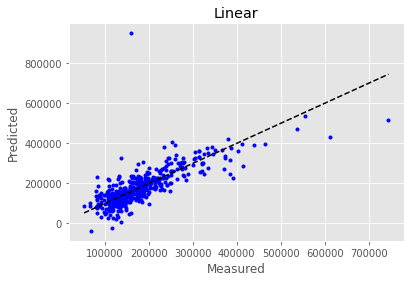

In [22]:
# plotting ops for linear model

fig, ax = plt.subplots()
ax.plot(y_val, y_val_pred_lr, 'b.') # plot the actual and predicted labels
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Linear')
plt.show()

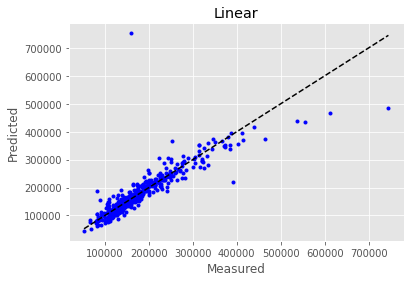

In [23]:
# plotting ops for lasso model

fig, ax = plt.subplots()
ax.plot(y_val, y_val_pred_lasso, 'b.') # plot the actual and predicted labels
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Linear')
plt.show()

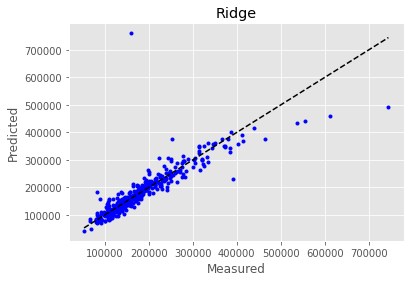

In [105]:
# plotting ops for ridge model

fig, ax = plt.subplots()
ax.plot(y_val, y_val_pred, 'b.') # plot the actual and predicted labels
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Ridge')
plt.show()

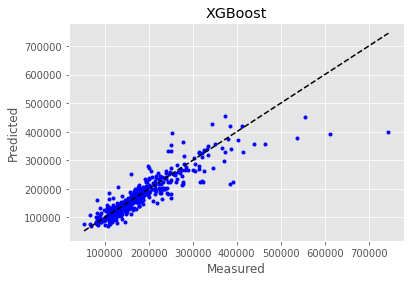

In [114]:
# plotting ops for xgboost

fig, ax = plt.subplots()
ax.plot(y_val, xg_y_pred, 'b.')
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('XGBoost')
plt.show()

In [29]:
# predicting for linear model on test samples trained on X_train(X[:test_n, :])

lr.fit(X[:test_n, :], price) # fitting training samples with their labels into the linear model - 1460 lables for 1022 training samples
y_submit = lr.predict(X_test) # predictin testing samples
y_submit[y_submit < 0] = 1. # if the predicted values is negative we replace it with 1.
test_data_frame['SalePrice'] = y_submit # adding a SalePrice column to our test data frame
test_data_frame.to_csv('linear_prediction.csv', columns = ['SalePrice']) # writing test data to a new csv file


In [24]:
# predicting for lasso model on test samples trained on X_train(X[:test_n, :])

lasso.fit(X[:test_n, :], price) # fitting training samples with their labels into the lasso model - 1460 lables for 1022 training samples
y_submit = lasso.predict(X_test) # predictin testing samples
y_submit[y_submit < 0] = 1. # if the predicted values is negative we replace it with 1.
test_data_frame['SalePrice'] = y_submit # adding a SalePrice column to our test data frame
test_data_frame.to_csv('lasso_prediction.csv', columns = ['SalePrice']) # writing test data to a new csv file

In [30]:
# predicting for ridge model on test samples trained on X_train(X[:test_n, :])

best.fit(X[:test_n, :], price) # fitting training samples with their labels into the ridge model - 1460 lables for 1022 training samples
y_submit = best.predict(X_test) # predictin testing samples
y_submit[y_submit < 0] = 1. # if the predicted values is negative we replace it with 1.
test_data_frame['SalePrice'] = y_submit # adding a SalePrice column to our test data frame
test_data_frame.to_csv('ridge_prediction.csv', columns = ['SalePrice']) # writing test data to a new csv file



In [31]:
# predicting for xgboost model on test samples trained on X_train(X[:test_n, :])

xmodel = xgb.train(params, xgb.DMatrix(X[:test_n, :], label=price)) # 1460 lables for 1022 training samples
y_submit = xmodel.predict(xgb.DMatrix(X_test)) # predictin testing samples
y_submit[y_submit < 0] = 1. # if the predicted values is negative we replace it with 1.
test_data_frame['SalePrice'] = y_submit # adding a SalePrice column to our test data frame
test_data_frame.to_csv('xgb_prediction.csv', columns = ['SalePrice']) # writing test data to a new csv file